In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Summary
both vanilla and mlp have big problems in trying to get anywhere near the target. Movement in mean (during run) is very similar.

In [2]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
    for c in cfgs_flat:
        c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
        c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
    configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../runs

two-dim/


In [4]:
rundir = basedir + "runs/two-dim/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

<ipython-input-2-23f8c11618f9>:52: UserWarning: Detected NaNs in dataframe. 1 / 64 rows include at least one NaN or inf. Dropping all rows with nonfinite values.
  warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")


In [19]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", "svgd_steps", "encoder_layers", "ksd_steps", "train", "lambda_reg"]
f = frame[relevant]
# f

# Hyperparameter comparison

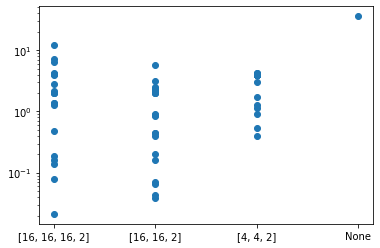

In [6]:
plt.scatter(f.encoder_layers, f.se_var)
plt.yscale("log")

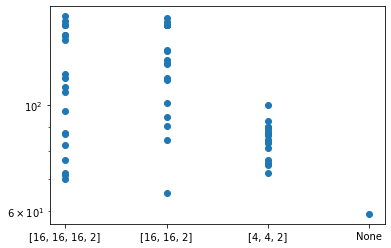

In [7]:
plt.scatter(f.encoder_layers, f.se_mean)
plt.yscale("log")

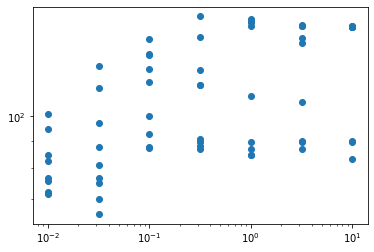

In [9]:
plt.scatter(f.lr_ksd, f.se_mean)
plt.yscale("log")
plt.xscale("log")

# Rundata

In [18]:
sweep_metaconfigs[0]["svgd"]["target_args"]

[[array([5.48813504, 7.15189366]),
  array([[2.64088548, 2.42920175],
         [2.42920175, 2.38665038]])]]

In [16]:
rundata[0].keys()

odict_keys(['Interrupted because of NaN', 'encoder_params', 'ksd_after_svgd_update', 'ksd_after_svgd_update_val', 'ksd_before_kernel_update', 'ksd_before_kernel_update_val', 'mean', 'particles', 'square_errors', 'training_mean', 'training_var', 'update_to_weight_ratio', 'validation_mean', 'validation_var', 'var'])

In [44]:
f[f.train == False]

,ksd,emd,lr ksd,svgd_steps,encoder_layers,ksd_steps,train
15,0.887482,11.032405,None,1,None,NaN,False


In [11]:
ind = 2
f.iloc[ind]

se_mean                       114.106
se_var                       0.399323
ksd                           7.41988
emd                           15.1555
lr ksd            0.31622776601683794
svgd_steps                          1
encoder_layers            [16, 16, 2]
ksd_steps                           5
train                            True
Name: 2, dtype: object

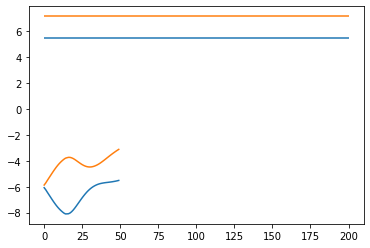

In [12]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 200, colors=colorcycle)

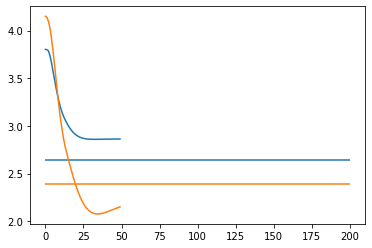

In [14]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 200, colors=colorcycle)

### KSD

In [19]:
n_iter = 200

In [21]:
ind = 2

In [28]:
frame.iloc[2]

emd                                                               5.0835
ksd                                                            0.0557701
se_mean                                                          10.8701
se_var                                                           57.0981
sinkhorn_divergence                                              25.8114
architecture                                                     Vanilla
layers                                                                []
n_particles                                                          200
optimizer_svgd                                                   Adagrad
lr svgd                                                              1.0
target                                                          Gaussian
target_args            [[5.4881350392732475, 7.151893663724195], [[2....
key                                                                    0
ksd_steps                                          

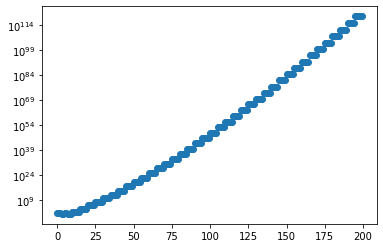

In [27]:
plt.plot(onp.array(rundata[ind]["ksd_after_svgd_update"]), "o", label="KSD after svgd update")
plt.yscale("log")

ValueError: x and y must have same first dimension, but have shapes (400,) and (200,)

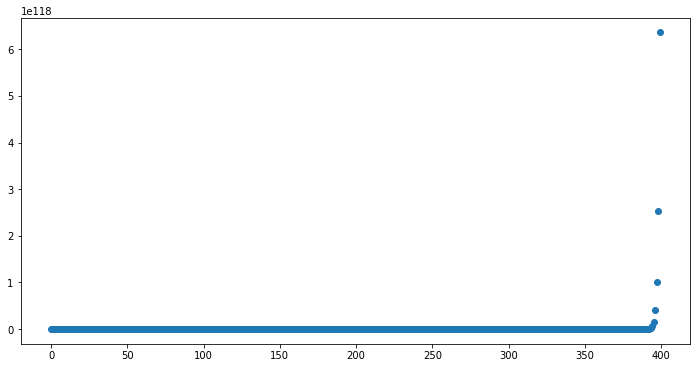

In [25]:
fig, ax = plt.subplots(figsize=[12, 6])
# idx = onp.arange(len(onp.array(rundata[ind]["ksd_after_kernel_update"])))
ax.plot(onp.array(rundata[ind]["ksd_after_kernel_update"]), "o", label="KSD after kernel update")

# ax.legend()
ax.set_yscale("log")

In [43]:
f

,ksd,emd,sinkhorn_divergence,lr ksd,svgd_steps,architecture,layers,ksd_steps
0,274.063647,17.590226,309.433619,0.1,1,MLP,"[32, 32, 32, 2]",1
1,233.723850,17.454214,304.662151,0.001,1,Vanilla,"[32, 32, 32, 2]",1
2,269.938762,17.675720,312.465914,0.01,1,MLP,"[32, 32, 32, 2]",1
3,231.515452,17.523217,307.072716,0.1,1,Vanilla,"[32, 32, 32, 2]",1
4,233.494401,17.556293,308.240974,0.01,1,Vanilla,"[32, 32, 32, 2]",1
5,225.633447,17.488249,305.855826,0.001,1,MLP,"[32, 32, 32, 2]",1
